# 多クラス分類の学習

## XGBoost

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [3]:
data = pd.read_csv("train.csv", decimal=",")
ds = data.values
ds

array([[1, 1, 0, ..., 0, 0, 'Class_1'],
       [2, 0, 0, ..., 0, 0, 'Class_1'],
       [3, 0, 0, ..., 0, 0, 'Class_1'],
       ...,
       [61876, 0, 0, ..., 0, 0, 'Class_9'],
       [61877, 1, 0, ..., 10, 0, 'Class_9'],
       [61878, 0, 0, ..., 2, 0, 'Class_9']], dtype=object)

In [4]:
data

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61873,61874,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,2,0,Class_9
61874,61875,4,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,Class_9
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,Class_9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,Class_9


In [5]:
data.describe(include='all')

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Class_2
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16122
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,...,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135,NaN
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,...,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720,NaN
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,15470.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,30939.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,46408.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [6]:
test = pd.read_csv("test.csv", decimal=",")
test

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,...,0,0,0,0,0,0,0,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144363,144364,0,0,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0,0
144364,144365,0,0,0,0,0,0,0,0,0,...,0,1,4,1,11,0,0,0,0,0
144365,144366,0,1,0,0,0,0,1,1,0,...,0,1,3,1,1,0,0,1,0,0
144366,144367,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,0,0,0,1,0


In [7]:
x_trdata = ds[:, 1:94]
y_trdata = ds[:, 94]

In [8]:
le = LabelEncoder()
y_trdata = le.fit_transform(y_trdata).astype(int)
y_trdata

array([0, 0, 0, ..., 8, 8, 8])

In [9]:
seed = 326
ts = 0.20

sss = StratifiedShuffleSplit(n_splits=1, test_size=ts, random_state=seed)
for train_idx, test_idx in sss.split(x_trdata, y_trdata):
    x_train = x_trdata[train_idx]
    y_train = y_trdata[train_idx]
    x_val = x_trdata[test_idx]
    y_val = y_trdata[test_idx]  

In [10]:
data.isnull().sum().sum()

0

<AxesSubplot:>

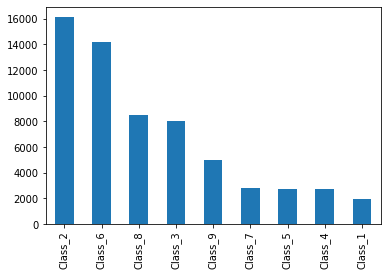

In [11]:
data["target"].value_counts().plot.bar()

In [12]:
display_all(data.describe())

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,0.263906,1.252869,0.140874,0.480979,1.696693,1.284398,1.413459,0.366108,0.575423,0.551699,0.471525,0.204014,0.729969,0.142522,2.643880,1.534520,0.563108,0.696613,0.238970,0.275768,0.150312,0.148680,1.043796,0.696516,0.946411,0.666263,0.709089,0.263632,0.582129,0.485585,1.653059,0.303468,0.698019,0.451146,0.560829,0.238130,0.641375,0.249669,1.584893,0.348314,0.324283,0.053298,0.213485,0.442063,2.072465,0.323120,0.303775,0.309108,0.697970,0.388603,1.029930,0.239746,1.187563,0.168590,1.256796,0.222228,0.571706,2.897653,0.392902,0.811128,0.892789,0.319290,0.858722,0.591050,0.579851,0.726817,0.748457,0.124196,0.366415,0.300446,0.698067,0.078461,0.187983,0.496719,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,1.083340,3.042333,0.567089,2.014697,3.163212,3.862236,2.226163,1.477436,1.335985,4.636145,1.438727,0.696050,1.446220,0.782979,4.629015,2.332994,1.710305,2.873222,0.828112,1.901294,1.640880,0.897354,2.416849,1.310202,3.368622,3.197965,2.555119,0.756934,1.602579,3.298315,3.299798,1.085672,1.961189,1.706013,1.346090,2.587131,2.348359,1.446203,2.577071,1.369380,1.720470,0.513820,1.044788,2.006485,4.113319,0.998743,1.925806,1.082148,3.983722,2.577693,3.028469,1.017553,2.666742,0.946158,3.402080,0.783052,1.361874,4.974322,1.761054,4.111091,1.941368,1.162443,2.411646,5.783233,3.757822,3.200095,2.920038,0.906621,2.778317,1.285569,2.245671,0.461244,0.836269,2.434921,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [13]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [14]:
pred = xgb.predict_proba(x_val)
print("Validation data logloss: {}".format(log_loss(y_val, pred)))

Validation data logloss: 0.48188992358736077


In [15]:
pred = xgb.predict(x_val)
accu = accuracy_score(y_val, pred)
print("Accuracy: %.2f%%" % (accu * 100.0))

Accuracy: 81.42%


In [16]:
lr_scores = []
learning_rates = [0.345, 0.350, 0.355]

for l in learning_rates:
    tune_xgb = XGBClassifier(use_label_encoder=False, learning_rate=l)
    tune_xgb.fit(x_train, y_train)
    pred = tune_xgb.predict_proba(x_val)
    lr_scores.append(log_loss(y_val, pred))
    print("learning_rate=%.3f, logloss: %.5f" % (l, log_loss(y_val, pred)))

learning_rate=0.345, logloss: 0.47723
learning_rate=0.350, logloss: 0.47421
learning_rate=0.355, logloss: 0.47629


best learning_rate 0.35


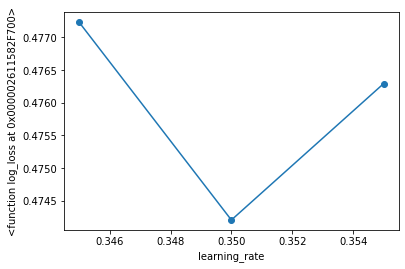

In [17]:
plt.plot(learning_rates, lr_scores, 'o-')
plt.ylabel(log_loss)
plt.xlabel("learning_rate")
print("best learning_rate {}".format(learning_rates[np.argmin(lr_scores)]))

In [18]:
pa = {'objective':'multi:sofprob',
      'learning_rate': 0.35,
     }

In [19]:
xgb = XGBClassifier(**pa, use_label_encoder=False)
model = CalibratedClassifierCV(xgb, cv=5, method="isotonic")
model.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None,
                                                    gamma=None, gpu_id=None,
                                                    grow_policy=None,
                                                    importance_type=None,
                                                    interaction_constraints=None,
                                                    learning_rate=0.35,
                                                    max_bin=None,
                                                    max_cat_to_onehot=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    max_leaves=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    n_estimators=100,
                                                    n_jobs=None,
                                                    num_parallel_tree=None,
                                                    objective='multi:sofprob',
                                                    predictor=None,
                                                    random_state=None,
                                                    reg_alpha=None, ...),
                       cv=5, method='isotonic')

In [20]:
pred = model.predict_proba(x_val)
print("Validation data logloss: {}".format(log_loss(y_val, pred)))

Validation data logloss: 0.4628408700108092


In [21]:
ds = test.values
ds

array([[     1,      0,      0, ...,      0,      0,      0],
       [     2,      2,      2, ...,      0,      2,      0],
       [     3,      0,      1, ...,      0,      0,      1],
       ...,
       [144366,      0,      1, ...,      1,      0,      0],
       [144367,      0,      0, ...,      0,      1,      0],
       [144368,      0,      0, ...,      0,      0,      0]], dtype=int64)

In [22]:
test.shape

(144368, 94)

In [23]:
x_test = ds[:, 1:94]
x_test

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 2,  2, 14, ...,  0,  2,  0],
       [ 0,  1, 12, ...,  0,  0,  1],
       ...,
       [ 0,  1,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [24]:
pred = model.predict_proba(x_test)
pred

array([[0.00000000e+00, 1.88199355e-01, 1.06343002e-01, ...,
        6.91058381e-03, 1.08569352e-04, 0.00000000e+00],
       [3.16431650e-03, 8.38208680e-03, 5.35171004e-04, ...,
        3.92670367e-03, 5.24648612e-01, 8.28392614e-04],
       [0.00000000e+00, 7.04736966e-05, 0.00000000e+00, ...,
        1.57883358e-04, 6.02903299e-04, 1.59141399e-04],
       ...,
       [0.00000000e+00, 5.55323526e-01, 2.49213800e-01, ...,
        6.59905955e-03, 1.01935449e-04, 0.00000000e+00],
       [0.00000000e+00, 1.99353055e-01, 8.03249086e-03, ...,
        2.21419337e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.56113289e-01, 3.01602483e-01, ...,
        8.48387658e-02, 1.01244940e-04, 4.72638293e-05]])

In [25]:
output = pd.DataFrame(pred, columns=["Class_1","Class_2","Class_3","Class_4","Class_5","Class_6","Class_7","Class_8","Class_9"])
output.index.name = "id"
output.index += 1
output

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
id,,,,,,,,,
1,0.000000,0.188199,0.106343,0.698009,0.000000,0.000429,0.006911,0.000109,0.000000
2,0.003164,0.008382,0.000535,0.000337,0.000216,0.457962,0.003927,0.524649,0.000828
3,0.000000,0.000070,0.000000,0.000000,0.000000,0.999010,0.000158,0.000603,0.000159
4,0.000000,0.611847,0.365047,0.021719,0.000000,0.000000,0.000161,0.000108,0.001118
5,0.131924,0.000069,0.001029,0.000182,0.000000,0.005973,0.002889,0.089794,0.768140
...,...,...,...,...,...,...,...,...,...
144364,0.653032,0.002491,0.004095,0.002956,0.000000,0.264888,0.023379,0.013318,0.035842
144365,0.000000,0.311804,0.525800,0.063729,0.000000,0.001084,0.097270,0.000100,0.000213
144366,0.000000,0.555324,0.249214,0.188328,0.000000,0.000433,0.006599,0.000102,0.000000


## LightGBM

In [26]:
train = data.copy()
train

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61873,61874,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,2,0,Class_9
61874,61875,4,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,Class_9
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,Class_9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,Class_9


In [27]:
train["target"] = train["target"].str.replace('Class_', '')
train["target"] = train["target"].astype(int) - 1

X_train = train.drop(['id','target'] , axis=1)
y_train = train["target"]
X_test = test.drop('id', axis=1)

In [28]:
y_pred = np.zeros((len(X_test), 9))
models = []
oof_train = np.zeros((len(X_train),9))

In [29]:
import lightgbm as lgb
from sklearn.model_selection import KFold

NFOLDS = 5

cv = KFold(n_splits=NFOLDS, shuffle=True, random_state=0)

params = {
    #'metric':'multi_logloss',
    'objective': 'multiclass',
    'num_class': 9,
    #'verbosity': 1,
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index].astype(int)
    y_val = y_train[valid_index].astype(int)
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val)
    
    model = lgb.train(params, lgb_train,
                        valid_sets=[lgb_train, lgb_eval],
                        verbose_eval=10,
                        num_boost_round=1000,
                        early_stopping_rounds=10)
    
    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred += model.predict(X_test, num_iteration=model.best_iteration)/NFOLDS

C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 49502, number of used features: 93
[LightGBM] [Info] Start training from score -3.457968
[LightGBM] [Info] Start training from score -1.343469
[LightGBM] [Info] Start training from score -2.036693
[LightGBM] [Info] Start training from score -3.148241
[LightGBM] [Info] Start training from score -3.114920
[LightGBM] [Info] Start training from score -1.476149
[LightGBM] [Info] Start training from score -3.083556
[LightGBM] [Info] Start training from score -1.990842
[LightGBM] [Info] Start training from score -2.539499
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.823215	valid_1's multi_logloss: 0.864415
[20]	training's multi_l

C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3124
[LightGBM] [Info] Number of data points in the train set: 49502, number of used features: 93
[LightGBM] [Info] Start training from score -3.479363
[LightGBM] [Info] Start training from score -1.344321
[LightGBM] [Info] Start training from score -2.046184
[LightGBM] [Info] Start training from score -3.143078
[LightGBM] [Info] Start training from score -3.113101
[LightGBM] [Info] Start training from score -1.476061
[LightGBM] [Info] Start training from score -3.101807
[LightGBM] [Info] Start training from score -1.981860
[LightGBM] [Info] Start training from score -2.521988
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.824283	valid_1's multi_logloss: 0.859057
[20]	training's multi_l

C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 49502, number of used features: 93
[LightGBM] [Info] Start training from score -3.461825
[LightGBM] [Info] Start training from score -1.347347
[LightGBM] [Info] Start training from score -2.053873
[LightGBM] [Info] Start training from score -3.124065
[LightGBM] [Info] Start training from score -3.119482
[LightGBM] [Info] Start training from score -1.477210
[LightGBM] [Info] Start training from score -3.073025
[LightGBM] [Info] Start training from score -1.989955
[LightGBM] [Info] Start training from score -2.512723
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.827495	valid_1's multi_logloss: 0.851461
[20]	training's multi_l

C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3130
[LightGBM] [Info] Number of data points in the train set: 49503, number of used features: 93
[LightGBM] [Info] Start training from score -3.478728
[LightGBM] [Info] Start training from score -1.342174
[LightGBM] [Info] Start training from score -2.043862
[LightGBM] [Info] Start training from score -3.126845
[LightGBM] [Info] Start training from score -3.130075
[LightGBM] [Info] Start training from score -1.481576
[LightGBM] [Info] Start training from score -3.067821
[LightGBM] [Info] Start training from score -1.993232
[LightGBM] [Info] Start training from score -2.516739
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.825059	valid_1's multi_logloss: 0.856851
[20]	training's multi_l

C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\09de1\Documents\python_basic\venv_python_basic\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 49503, number of used features: 93
[LightGBM] [Info] Start training from score -3.463133
[LightGBM] [Info] Start training from score -1.347601
[LightGBM] [Info] Start training from score -2.045579
[LightGBM] [Info] Start training from score -3.134243
[LightGBM] [Info] Start training from score -3.110399
[LightGBM] [Info] Start training from score -1.471583
[LightGBM] [Info] Start training from score -3.082694
[LightGBM] [Info] Start training from score -1.990862
[LightGBM] [Info] Start training from score -2.533139
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.825677	valid_1's multi_logloss: 0.860416
[20]	training's multi_l

In [30]:
sampleSubmission = pd.read_csv('sampleSubmission.csv')

In [31]:
submit = pd.concat([sampleSubmission[['id']], pd.DataFrame(y_pred)], axis = 1)
submit.columns = sampleSubmission.columns

In [32]:
submit

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.000282,0.122305,0.179536,0.693218,1.187347e-07,0.000217,0.004264,0.000167,0.000013
1,2,0.000812,0.014184,0.000825,0.000370,7.970077e-06,0.717289,0.001086,0.264772,0.000655
2,3,0.000005,0.000027,0.000017,0.000004,6.824787e-09,0.999524,0.000010,0.000407,0.000006
3,4,0.000052,0.603163,0.391107,0.004824,7.746995e-08,0.000067,0.000092,0.000081,0.000615
4,5,0.171684,0.000384,0.000599,0.000188,1.209310e-06,0.003676,0.009849,0.114888,0.698732
...,...,...,...,...,...,...,...,...,...,...
144363,144364,0.390072,0.009499,0.007277,0.007681,8.615828e-07,0.490272,0.033270,0.019173,0.042754
144364,144365,0.000400,0.305566,0.547436,0.079166,1.369958e-06,0.000881,0.066321,0.000128,0.000100
144365,144366,0.000148,0.653945,0.237071,0.107045,2.511128e-07,0.000478,0.001215,0.000067,0.000032
144366,144367,0.000025,0.155263,0.012583,0.831956,3.728673e-08,0.000020,0.000142,0.000007,0.000004
